# Академия Аналитиков Авито

# Эконометрика

# Домашняя работа №4

In [ ]:
import pandas as pd
import seaborn as sns
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox

from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.ar_model import ar_select_order

## №1 (40 баллов)

- Вам дан файлик `HW_004_001.csv`
- В нем находится одномерный временной ряд
- Ваша задача подобрать лучшую модель, которая бы описывала эти данные

- Начнем с чего простого. Загрузим данные

In [ ]:
df = pd.read_csv('HW_004_001.csv')

In [ ]:
df.describe()

,y
count,1000.000000
mean,9.052874
std,3.693072
min,-1.819417
25%,6.461043
50%,9.195403
75%,11.683851
max,19.802283


In [ ]:
df.head()

,date,y
0,2018-07-18,0.101160
1,2018-07-19,0.622773
2,2018-07-20,-0.796028
3,2018-07-21,3.154209
4,2018-07-22,1.800747


In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [ ]:
df

,date,y
0,2018-07-18,0.101160
1,2018-07-19,0.622773
2,2018-07-20,-0.796028
3,2018-07-21,3.154209
4,2018-07-22,1.800747
...,...,...
995,2021-04-08,13.486392
996,2021-04-09,17.259072
997,2021-04-10,11.866829
998,2021-04-11,14.866010


- Нарисуем данные

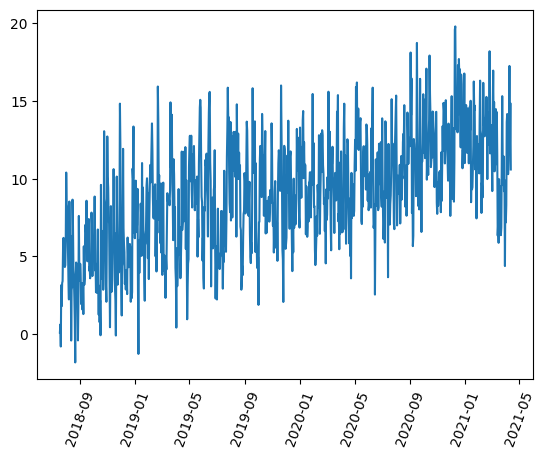

In [ ]:
plt.plot(df["date"], df["y"])
plt.xticks(rotation=70)
plt.show()

- Можно ли что-то сказать про данные судя по графику?

Да, в них очевидно прослеживается положительный тренд и сезонность, поэтому процесс скорее всего окажется нестационарным.

- Нарисует `ACF()`, `PACF()`

/home/kseniya/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


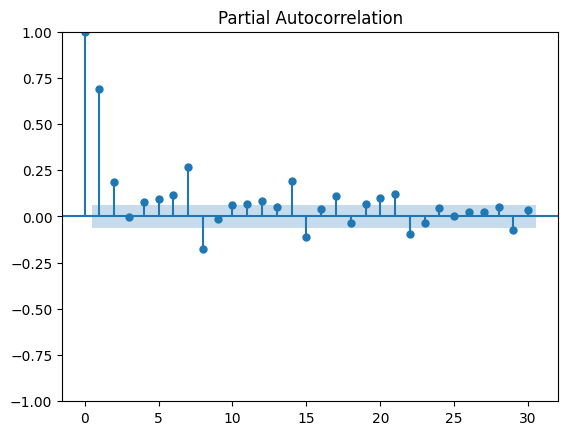

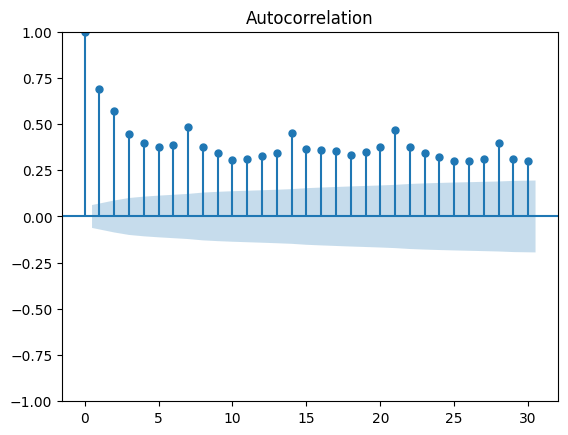

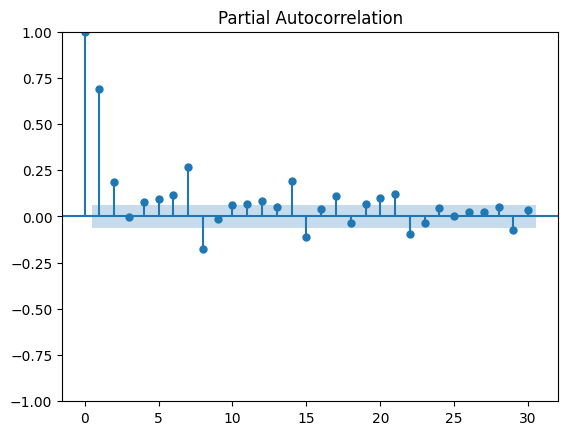

In [ ]:
plot_acf(df["y"])
plot_pacf(df["y"])

- Можно ли сделать какой-то вывод?

По ACF очевидно, что ряд не стационарен и тренд есть (лаги положительные, медленно уменьшаются, не достигают нуля), также очевидно, что есть сезонность - каждый 6 лаг сильно скоррелирован.
ACF геометрически убывает (с поправкой на сезонность), у PACF (тоже с поправкой на сезонность) значим первый лаг - поэтому я бы предположила, глядя на графики, что это AR процесс с сезонностью и трендом.

- Ну а теперь ваша свобода 
- Продолжите анализ
    - Не забывайте про стационарность
    - А как насчет тренда?
    - Есть ли сезонность?
    - Может быть в [документации](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html) будут еще полезные трюки
    - А может быть будет что-то полезное в [учебнике](https://otexts.com/fpp2/)

Посмотрим на тесты чтобы сделать однозанчный вывод о стационарности ряда.

In [ ]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [ ]:
adf_test(df['y'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.657991
p-value                          0.081594
#Lags Used                      21.000000
Number of Observations Used    978.000000
Critical Value (1%)             -3.437054
Critical Value (5%)             -2.864500
Critical Value (10%)            -2.568346
dtype: float64


In [ ]:
kpss_test(df['y'])

Results of KPSS Test:
Test Statistic            4.263181
p-value                   0.010000
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/kseniya/.local/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Оба теста на 10-процентном уровне значимости говорят о том, что ряд нестационарен.

Попробую взять разности, чтобы ряд стал стационарным

In [ ]:
delta_index = (df['y'] - df['y'].shift()).dropna()

In [ ]:
adf_test(delta_index)

Results of Dickey-Fuller Test:
Test Statistic                -1.110450e+01
p-value                        3.792430e-20
#Lags Used                     2.000000e+01
Number of Observations Used    9.780000e+02
Critical Value (1%)           -3.437054e+00
Critical Value (5%)           -2.864500e+00
Critical Value (10%)          -2.568346e+00
dtype: float64


In [ ]:
kpss_test(delta_index)

Results of KPSS Test:
Test Statistic            0.120416
p-value                   0.100000
Lags Used                96.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/kseniya/.local/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Судя по тестам, ряд стал стационарным. (КПСС тест, как мне кажется, как-то не очень правильно пишет p-value)

Перейду к подбору модели.

In [80]:
!pip install pmdarima
from pmdarima.arima import auto_arima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.5 MB/s eta 0:00:00


Я возьму первоначальный ряд без разностей и ожидаю увидеть SARMA (p, 1, q) модель

In [ ]:
model = auto_arima(df['y'], start_p=0, start_q=0, seasonal=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2346.014
Date:                Fri, 14 Apr 2023   AIC                           4700.027
Time:                        19:22:37   BIC                           4719.654
Sample:                             0   HQIC                          4707.487
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0041      0.001      4.023      0.000       0.002       0.006
ar.L1          0.4993      0.030     16.677      0.000       0.441       0.558
ma.L1         -0.9891      0.006   -179.440      0.000      -1.000      -0.978
sigma2         6.3986      0.276     23.193      0.000       5.858       6.939
===================================================================================
Ljung-Box (L1) (Q):                   2.04   Jarque-Bera (JB):                14.71
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.28
Prob(H) (two-sided):                  0.43   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

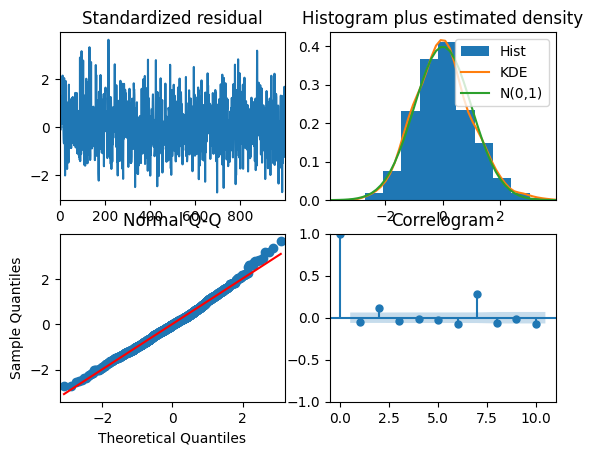

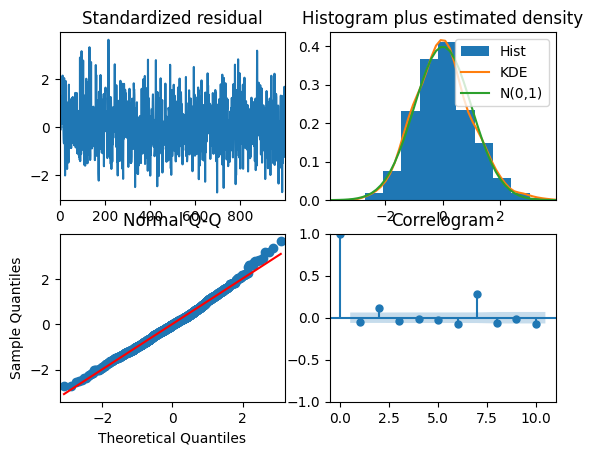

In [ ]:
model.plot_diagnostics()

Моделью, которая лучше всего объяснят Y оказалась SARIMA(1, 1, 1). Все коэффициенты значимы. 

**Далее будет две задачи. Вам надо выбрать одну. Если вы сделаете и 2.1, и 2.2, то будет выбран минимальный балл из двух**

## №2.1 (60 баллов)

Я взяла эту задачу, поэтому дальше будет много копипаста из семинарского ноутбучка..

In [ ]:
pip install plotly

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy as sp

import statsmodels.formula.api as smf
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

import scipy as sp
import seaborn as sns

# Модельки
from statsmodels.tsa.arima.model import ARIMA
# Тесты
from statsmodels.tsa.stattools import adfuller, kpss, acf

import prophet as fp 
import datetime
import time

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import add_changepoints_to_plot


import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

# инициализируем plotly
init_notebook_mode(connected = True)

pd.set_option('display.max_columns', None) # Чтобы показывались все колонки
%matplotlib inline

In [2]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput, '\n Null Hypothesis: The series has a unit root.')
    
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output, '\n Null Hypothesis: The process is trend stationary.')

In [3]:
# опишем функцию, которая будет визуализировать все колонки dataframe в виде line plot
def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title, template='plotly_white')
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)
    
# Функция для получения данных 'mdape', 'mape', 'mtape' для модели по методу имитированных исторических прогнозов
def perf_metrics_28d(fp_model):
    fp_df_cv = cross_validation(fp_model, initial='730.25 days', period='28 days', horizon = '28 days', parallel="processes")
    res = performance_metrics(fp_df_cv,rolling_window = 1)
    return res

- Не буду расписывать задание (как самый настоящий менеджер)
- На занятии вы разбирали данные о продажах Walmart для прогнозирования ежедневных продаж на следующие 28 дней. С кейсом можно озанкомиться на kaggle: [M5 Forecasting - Uncertainty](https://www.kaggle.com/c/m5-forecasting-uncertainty/overview). Продолжим с ними работать.
- Вам необходимо сделать модель предсказания продаж в штате Висконсин (WI) категории Hobbies в целом (не углубляясь до торговых точек)
- Данные берем [отсюда](https://www.kaggle.com/c/m5-forecasting-uncertainty/data)

In [37]:
# Тренировочный датафрейм с проданными айтемами
sales_train_evaluation = pd.read_csv('sales_train_evaluation.csv')

In [38]:
# Получение и обработка исходных данных.

# Будем работать не с каждой конкретной точкой, а с продажами в каждом конкретном штате по категориям
stv_cols = [c for c in sales_train_evaluation.columns if c not in ['id','item_id','dept_id','store_id']]
sales_train_evaluation = sales_train_evaluation[stv_cols].groupby(['cat_id','state_id'], as_index = False).sum()

# Преобразуем данные в удобный формат
stv_cols_tr = [c for c in stv_cols if c not in ['cat_id','state_id']]
sales_train_evaluation = pd.melt(sales_train_evaluation, id_vars = ['cat_id','state_id'], value_vars = stv_cols_tr)

In [39]:
# Cправочник дат. SNAP - индикатор участия магазина в программе льготной покупки продуктов (Supplemental Nutrition Assistance Program)
calendar = pd.read_csv('calendar.csv', parse_dates = ['date'])
calendar['date'] = calendar.date.dt.date
calendar = calendar[['date', 'd', 'event_name_1','event_type_1','event_name_2','event_type_2', \
                     'snap_CA', 'snap_TX', 'snap_WI']]

In [40]:
# Присоединение дат к id
sales_train_evaluation.columns = ['cat_id', 'state_id', 'd', 'y']
sales_train_evaluation = sales_train_evaluation.merge(calendar[['d', 'date']], how = 'left', on = 'd')

In [41]:
# Приведение к нужному для fbprophet виду
sales_train_evaluation = sales_train_evaluation[['date', 'state_id', 'cat_id', 'y']]
sales_train_evaluation.columns = ['ds', 'state_id', 'cat_id', 'y']

In [42]:
# Помните, что вам нужно выбрать нужные данные (штат Висконсин и категория Хобби)

wi_data = sales_train_evaluation.loc[sales_train_evaluation.state_id == 'WI', ['ds', 'cat_id', 'y']].copy()
data = wi_data.loc[(wi_data.cat_id == 'HOBBIES')&(wi_data.ds<=datetime.date(2016,4,24)),['ds', 'y']].copy().reset_index(drop = True)


In [43]:
data.head()

,ds,y
0,2011-01-29,1083
1,2011-01-30,926
2,2011-01-31,684
3,2011-02-01,455
4,2011-02-02,132


(Половину задания я делала в колабе, потому что по какой-то причине юпитеру от этого датасета стало плохо, метод ниже нужен по идее только в колабе)

In [30]:
def enable_plotly_in_cell():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
  init_notebook_mode(connected=False)

In [ ]:
# Нарисуйте
enable_plotly_in_cell()
plotly_df(data.set_index('ds'), title = 'WI items sold in Hobbies category')

- Что можете сказать?  


Виден слабый положительный тренд, сезонность менее очевидна на графике, но зная что это данные продаж, она точно есть. Есть праздники с аномально низкими продажами - 23 ноября (день благодарения) и 31 декабря. Я пыталась найти периоды перед праздниками, в которые, как мне кажется, продажи в категории хобби должны увеличиваться (Хэлоуин, дни перед Рождеством), но на таком графике без декомпозиции эти периоды незаметны.

In [47]:
# Попробуйте зафиттить базовую модель

# 1. Создадим объект класса Prophet (все параметры модели задаются в конструкторе класса, используем дефолтные)
m = fp.Prophet()

# 2. Проведем обучение
m.fit(data)

# 3. Cоздадим таблицу с датами, охватывающими даты истории + "горизонт" для прогнозирования
future = m.make_future_dataframe(periods=28)

# 4. Получим предсказания на датах, полученных в предыдщуем шаге
forecast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [34]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-29,703.860612,827.401593,1153.940450,703.860612,703.860612,280.833050,280.833050,280.833050,254.868722,254.868722,254.868722,25.964327,25.964327,25.964327,0.0,0.0,0.0,984.693662
1,2011-01-30,703.819494,587.536861,909.160361,703.819494,703.819494,44.511347,44.511347,44.511347,14.564648,14.564648,14.564648,29.946700,29.946700,29.946700,0.0,0.0,0.0,748.330842
2,2011-01-31,703.778377,488.121201,803.990613,703.778377,703.778377,-61.804431,-61.804431,-61.804431,-95.192609,-95.192609,-95.192609,33.388177,33.388177,33.388177,0.0,0.0,0.0,641.973945
3,2011-02-01,703.737259,483.201774,792.113655,703.737259,703.737259,-72.035313,-72.035313,-72.035313,-108.329224,-108.329224,-108.329224,36.293910,36.293910,36.293910,0.0,0.0,0.0,631.701946
4,2011-02-02,703.696142,503.652676,823.146236,703.696142,703.696142,-34.961815,-34.961815,-34.961815,-73.639187,-73.639187,-73.639187,38.677372,38.677372,38.677372,0.0,0.0,0.0,668.734327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,2016-05-18,974.937672,732.079104,1055.336285,974.831587,975.012001,-74.882634,-74.882634,-74.882634,-73.639187,-73.639187,-73.639187,-1.243447,-1.243447,-1.243447,0.0,0.0,0.0,900.055038
1937,2016-05-19,975.214760,725.843230,1054.445225,975.094907,975.308570,-82.471408,-82.471408,-82.471408,-82.843151,-82.843151,-82.843151,0.371742,0.371742,0.371742,0.0,0.0,0.0,892.743352
1938,2016-05-20,975.491847,909.018654,1241.968598,975.350267,975.608631,92.683616,92.683616,92.683616,90.570800,90.570800,90.570800,2.112817,2.112817,2.112817,0.0,0.0,0.0,1068.175464
1939,2016-05-21,975.768935,1071.853285,1393.587035,975.609230,975.913227,258.844863,258.844863,258.844863,254.868722,254.868722,254.868722,3.976141,3.976141,3.976141,0.0,0.0,0.0,1234.613799


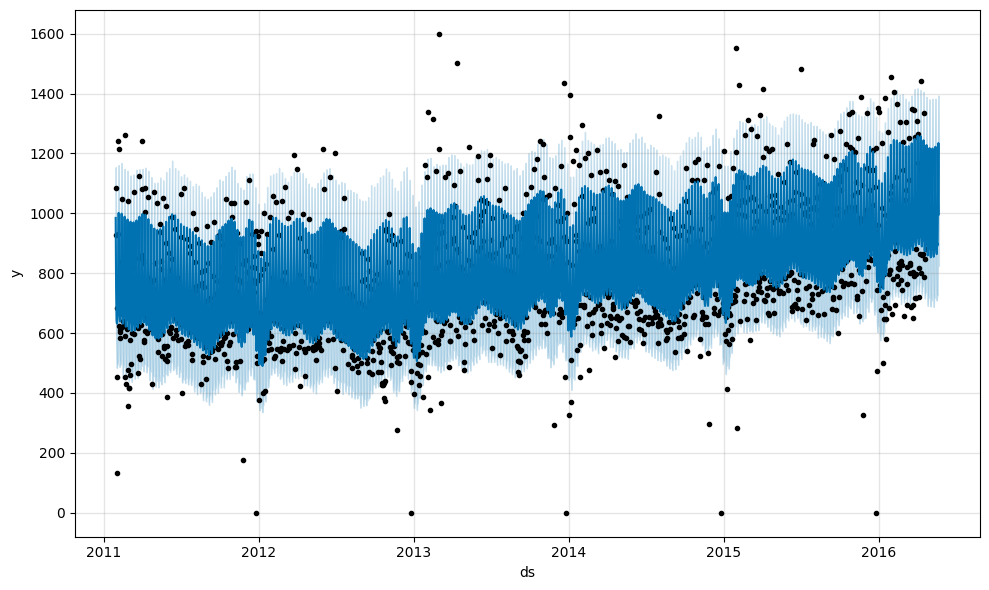

In [35]:
fig1 = m.plot(forecast)

- Что у вас получилось? 
- Что еще можете сказать, скажем, по поводу компонентов модели?


Выглядит так, словно наша модель склонна завышать прогноз - большое количество точек входит в ДИ, но не входят в прогноз. Такое поведение наблюдается на всех периодах.

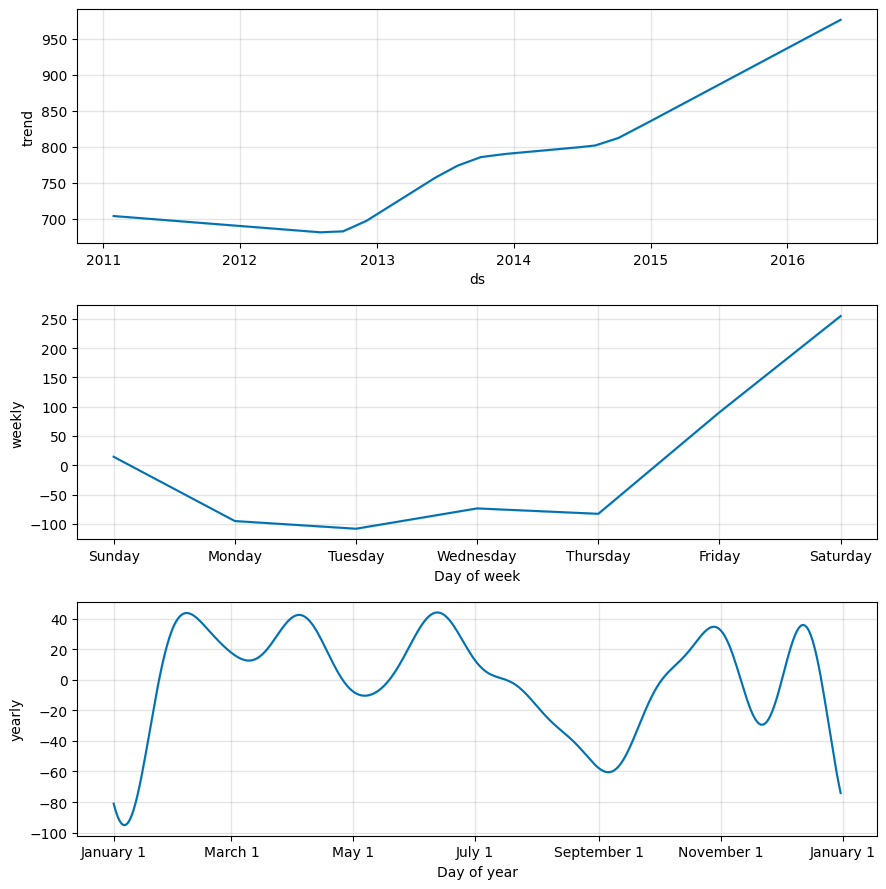

In [48]:
fig2 = m.plot_components(forecast)

Есть существенный положительный тренд в категории.

Видно, что пиковые продажи по категории хобби происходят в пятницу и субботу - видимо люди склонны приобретать товары для хобби вечером после рабочей пятницы или в субботу (видимо когда еще есть время эти товары использовать)

А в рамках одного года сильнее всего проседают рождественские каникулы и почему-то конец августа-начало сентября...

- На занятии вам показывали 100500 параметров, с которыми можно поиграться, чтобы получить "лучшую" модель
- Во-первых, начнем с последнего, какзалось бы, шага. Какую метрику вы будете использовать? Почему?
- Каким именно способом вы будете проводить диагностику модели и сравнивать модели?
- Какие параметры вы будете менять? Почему? Попробуйте предположить, как именно необходимо поменять параметр модели, прежде чем приступать к тестированию. За неверное предположение баллы сниматься не будут при наличии обоснования.
- Как еще можно улучшить модель? Что можно добавить еще?

Я бы использовала MAPE или какую-то ее модификацию (а именно я бы взяла Symmetric MAPE).
Именно MAPE, потому что она представляет ошибки в виде процентов, а значит модели очень удобно сравнивать между собой и интерпретировать эти ошибки.

Но у самой МАРЕ есть проблема с тем, что недопрогноз штрафуется максимум на единицу, а перепрогноз может быть оштрафован любым числом. (Но глядя на то, как обучилась наша модель сейчас - если бы использовалась МАРЕ и предпочтение отдавалось недопрогнозу - было бы только лучше, потому что в случае прибыли мне хотелось бы получить скорее консервативный и рискофобный прогноз). Так что для простоты остановлюсь на МАРЕ

In [58]:
data_evaluation = wi_data.loc[(wi_data.cat_id == 'HOBBIES'),['ds', 'y']].copy().reset_index(drop = True)

In [59]:
# посчитаем MAPE для тестового периода

# преобразуем формат для джойна табличек
data_evaluation['ds'] = pd.to_datetime(data_evaluation['ds'])
data['ds'] = pd.to_datetime(data['ds'])
data_w_error = data_evaluation.merge(forecast[['ds','yhat']], on = ['ds'], how='left')

# считаем ошибку
data_w_error['mape'] = abs(data_w_error['y'] - data_w_error['yhat'])/data_w_error['y']


print('MAPE is: ', np.mean(data_w_error[data_w_error['ds']>max(data['ds'])]['mape']))

MAPE is:  0.08282873584488173


Диагностику в идеальном мире надо проводить примерно так: посмотреть после обучения на график прогноза; посмотреть на распределение остатков - в идеале нормальное, на автокорреляцию - точнее на ее отсутствие, pacf - что остатки уменьшаются до нуля. Или просто выделить часть датасета под кроссвалидацию.

Сравнивать модели тоже проще всего с помощью кросс-валидации. Самый простой способ это обучить модели на тестовом датасете, а затем выбрать лучшую с помощью наименьшей ошибки средней ошибки на кросс-валидации (которая собирается как расширяющееся окно - так как у нас относительно небольшая выборка, которая при этом очевидно не стационарна из-за тренда и имеет сезонность, лучше использовать имеено расширяющееся окно) 

In [60]:
pb_metrics = perf_metrics_28d(m)
pb_metrics

INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f703ba869a0>
INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,28 days,19888.585867,141.026898,102.563197,0.097804,0.127618,0.816327


In [ ]:
enable_plotly_in_cell()
plotly_df(data_w_error.set_index('ds')[['y', 'yhat']], title = 'Fact vs Forecast')

Мне кажется, что тренд менялся не больше двух раз - в конце 2012, и возможно в середине 2014 - поэтому я поменяю n_changepoints на 2

И сезональность, как мне кажется, мультипликативная - мне кажется, есть сильное изменения в ней со временем, поэтому я поставлю seasonality_mode = 'multiplicative' (добавлю стандартную годовую и месячную)

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


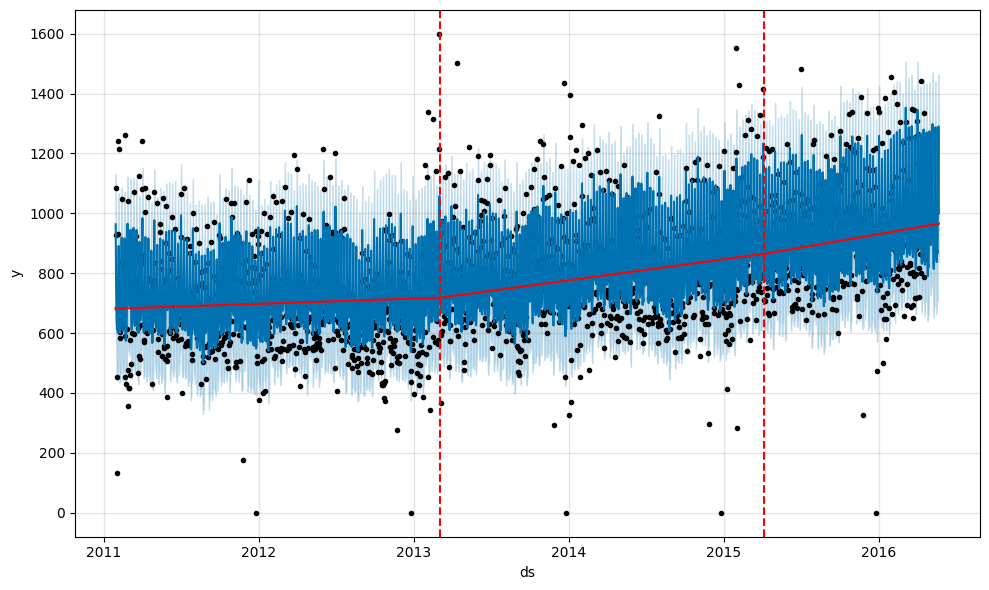

In [84]:
# 1. Создадим объект класса Prophet (все параметры модели задаются в конструкторе класса, используем дефолтные)
m_1 = fp.Prophet(
    n_changepoints=2,
    seasonality_mode = 'multiplicative'
    )
m_1.add_seasonality(name = 'yearly', 
                       period = 365.25,
                       fourier_order = 3, 
                       mode = 'additive')

m_1.add_seasonality(name = 'monthly', 
                       period = 30.5,
                       fourier_order = 3, 
                       mode = 'additive')

# 2. Проведем обучение
m_1.fit(data)

# 3. Cоздадим таблицу с датами, охватывающими даты истории + "горизонт" для прогнозирования
future = m_1.make_future_dataframe(periods=28)

# 4. Получим предсказания на датах, полученных в предыдщуем шаге
forecast = m_1.predict(future)

fig3 = m_1.plot(forecast)

# Добавим сетку с точками изменения тренда (профет берет не все 25, а лишь отбирает не больше 25)
a = add_changepoints_to_plot(fig3.gca(), m_1, forecast)

In [86]:
pb_metrics = perf_metrics_28d(m_1)
pb_metrics

INFO:prophet:Making 42 forecasts with cutoffs between 2013-02-03 00:00:00 and 2016-03-27 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f7015f645b0>
INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,28 days,18758.239998,136.960724,100.540773,0.092464,0.125178,0.818027


- А что если попробовать воспользоваться моделями другого класса? Давайте воспользуемся моделями класса [SARIMAX](https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_stata.html). Это обобщение класса SARIMA. Исопльзование внешних регрессоров не обязательно.
- Является временной ряд, с которым вы работаете стационарным? Тренд стационарым? Стационарным в разностях?
- Сколько лагов стоит использовать?

Figure(640x480)
Figure(640x480)


/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



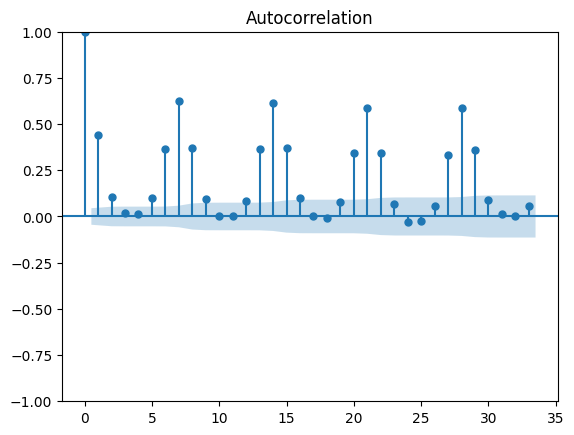

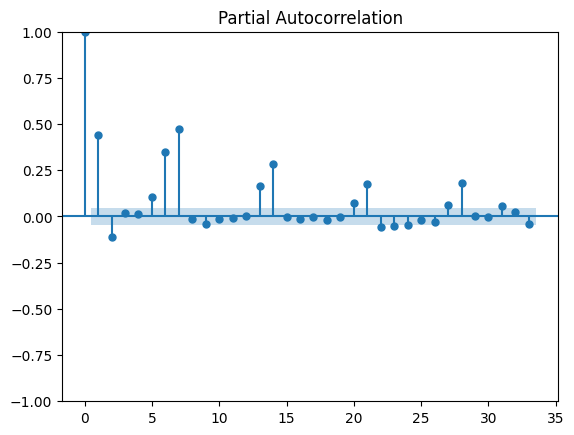

In [70]:
print(plot_acf(data.y))
print(plot_pacf(data.y))

In [71]:
adf_test(data.y)

Results of Dickey-Fuller Test:
Test Statistic                   -3.021206
p-value                           0.032961
#Lags Used                       26.000000
Number of Observations Used    1886.000000
Critical Value (1%)              -3.433822
Critical Value (5%)              -2.863074
Critical Value (10%)             -2.567586
dtype: float64 
 Null Hypothesis: The series has a unit root.


In [72]:
kpss_test(data.y)

Results of KPSS Test:
Test Statistic            8.153917
p-value                   0.010000
Lags Used                14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64 
 Null Hypothesis: The process is trend stationary.


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




Наш временной ряд не стационарен и не транд-стационарен, посмотрим на разности.

In [74]:
data['y_diff'] = data.y.diff().dropna()

Figure(640x480)
Figure(640x480)


/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



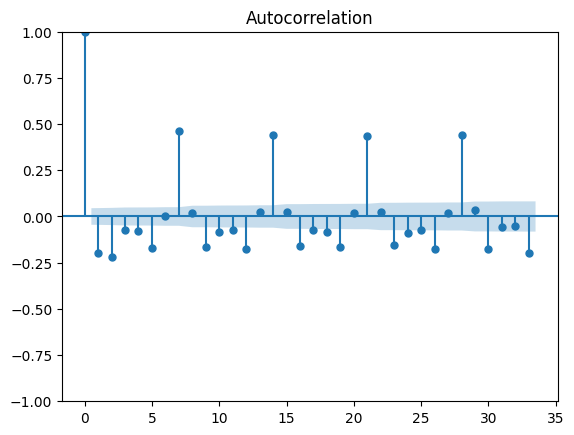

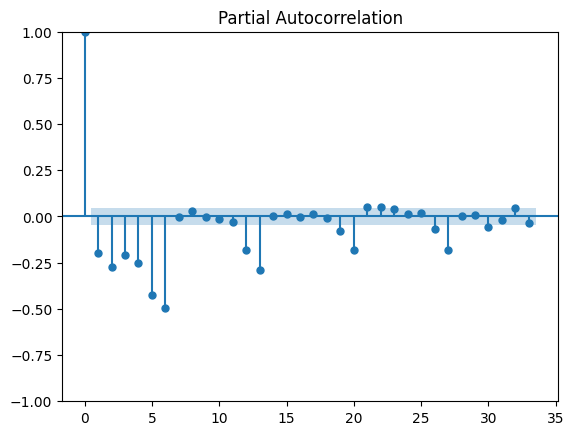

In [75]:
print(plot_acf(data['y_diff'].dropna()))
print(plot_pacf(data['y_diff'].dropna()))

In [76]:
print(adf_test(data['y_diff'].dropna()),'\n')
print(kpss_test(data['y_diff'].dropna()))

Results of Dickey-Fuller Test:
Test Statistic                -1.407652e+01
p-value                        2.878376e-26
#Lags Used                     2.600000e+01
Number of Observations Used    1.885000e+03
Critical Value (1%)           -3.433824e+00
Critical Value (5%)           -2.863075e+00
Critical Value (10%)          -2.567587e+00
dtype: float64 
 Null Hypothesis: The series has a unit root.
None 

Results of KPSS Test:
Test Statistic            0.046148
p-value                   0.100000
Lags Used                58.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64 
 Null Hypothesis: The process is trend stationary.
None


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




А вот в разностях ряд стационарен. Подберу SARIMA-модель

In [81]:
model = auto_arima(data['y'], start_p=0, start_q=0, seasonal=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1913
Model:               SARIMAX(5, 1, 3)   Log Likelihood              -12226.673
Date:                Fri, 14 Apr 2023   AIC                          24473.346
Time:                        20:11:07   BIC                          24528.905
Sample:                             0   HQIC                         24493.792
                               - 1913                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3829      0.377      1.017      0.309      -0.355       1.121
ar.L1          1.2620      0.033     38.496      0.000       1.198       1.326
ar.L2         -1.1882      0.042    -28.088      0.000      -1.271      -1.105
ar.L3          0.3191      0.053      5.966      0.000       0.214       0.424
ar.L4         -0.2751      0.041     -6.782      0.000      -0.355      -0.196
ar.L5          0.0848      0.031      2.739      0.006       0.024       0.146
ma.L1         -2.0745      0.023    -89.001      0.000      -2.120      -2.029
ma.L2          2.0136      0.031     65.376      0.000       1.953       2.074
ma.L3         -0.8533      0.022    -38.962      0.000      -0.896      -0.810
sigma2      2.537e+04    616.136     41.176      0.000    2.42e+04    2.66e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):              1390.99
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                            -0.29
Prob(H) (two-sided):                  0.08   Kurtosis:                         7.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Получается лучшая модель это SARIMA(5, 1, 3)

- А теперь давайте сравним предсказания моделей двух классов.
- Каким тестом воспользуетесь?
- Какие у данного теста есть ограничения?
- Какую модель в итоге будете использовать?

Я бы воспользовалась Diebold-Mariano test, но у него есть ограничения на вложенность моделей и на линейность (ну профит очевидно не линейный) (не совладала с pd, чтобы к правильному виду привести даты :^) )

**Опционально**
- Можете посмотреть также на [Model Confidence Set](http://www.econ.upf.edu/~lugosi/hansen.pdf) (в [R](https://deliverypdf.ssrn.com/delivery.php?ID=721006122086126029008122096102104025121057026076017028009004070073075030011117018067003018063048018122018101098004022095096104106042011054015086010014019009066093071037037090073072109011022065022092067068097122090073100031093118107026068100105029083&EXT=pdf&INDEX=TRUE)) 
- Какое-то подобие на [Python](https://michael-gong.com/blogs/model-confidence-set/)

## №2.2 (60 баллов)


- Вы хотите применить свои знания моделей временных рядов для предсказания движения цен акций
- Для этого вы используете библиотеку `yfinance` (советую устанавливать с помощью `pip`, а не `conda install`), чтобы скачать котировки акций
- Вы должны выбрать одну акцию, которая есть в этом источнике и которая вам нравится
- После этого вы должны сделать все то же, самое, что делали в прошлом пункте - выбрать лучше модель, которая описывает данные
- Надеюсь, вы помните, что я говорил про цены и доходности, на занятии
- Однако вас волнует больше всего предсказательная способность модели, а не то, насколько хорошо она описывает данные
- В качестве аналога кросс валидации для моделей временных рядов используется бэктестирование с помощью скользящего или расширяющегося окна:
    1. Фиттим модель за период $\{0 ... t\} \rightarrow \text{ делаем предсказание } \hat{r}_{t+1}$
    2. Если скользящее окно, то фиттим модель за период $\{1 ... t+1\} \rightarrow \text{ делаем предсказание } \hat{r}_{t+2}$
       Если расширяющееся окно, то фиттим модель за период $\{0 ... t+1\} \rightarrow \text{ делаем предсказание } \hat{r}_{t+2}$
    3. Делаем так столько раз, сколько считаем нужным. Обычно, в качестве out-of-sample выборки берется 20%-30% от выборки
    4. Например, у нас 1000 наблюдений. Считаем, что 30% наблюдений пойдут для out-of-sample предсказаний. Тогда:
        - На шаге 1 мы фиттим модель на 1-700 наблюдениях и делаем предсказание для 701 наблюдения
        - На шаге 2 (предположим, что у нас скользящее окно) мы фиттим модель на 2-701 наблюдениях и делаем предсказание для 702 наблюдения
        - Последним является предсказание для 1000-го наблюдения 
        - В итоге, имеем вектор предсказаний для 701-1000 наблюдений и их фактические значения, т.е. можем посчитать те или иные метрики качества (MSE, MAE, RMSE и т.п.)
        - Выбираем модель, у которой будет наилучшая метрика качества
- Однако, это не все. Наша цель использовать эту наилучшую модель для того, чтобы обыгрывать фондовый рынок. 
    - Например,
        - $t=0, P_0 = 100$
        - $t=1, P_1 = 110 \rightarrow r_1 = 0.1, \hat{r}_2 = 0.2 \rightarrow \text{ вы покупаете акцию и стоимость вашего портфеля } V = 110 \text{ равна цене акции}$
        - $t=2, P_2 = 105, r_2 = -0.045, \text{ т.е. вы ошиблись, и стоимость вашего портфеля упала} V = 105 \text{ вы продолжаете использовать модель и делаете новое предсказание } \hat{r}_3 = -0.01 \text{ предсказание получилось отрицательным. Что вы будете делать? Продадите акцию?}$
- Дам вам возможность шортить акции бесплатно. Почитать, что это такое, можно [тут](https://place.moex.com/useful/short-i-long-na-fondovom-rynke). Однако шорт - не обязателен, будет нормально, если вы будете просто продавать акцию и держать наличные деньги в портфеле.
- Собственно, вы должны подумать, как лучше использовать предсказания, чтобы по окончанию out-of-sample периода у вас был портфель с наибольшей стоимостью. Не забудь сравнить результат этой стратегии со стратегией, когда вы покупаете акцию в самый первый момент времени и держите ее до конца (buy & hold).
- Можете почитать [эту](https://www.quantstart.com/articles/ARIMA-GARCH-Trading-Strategy-on-the-SP500-Stock-Market-Index-Using-R/) статью в качестве пример (внимание! Там `R`)

- Результаты вашей работы потом будут показы CIO (Chef Investment Officer), который даст или не даст свое разрешение на распределение капитала на вашу модель+торговую стратегию
- CIO не хочет тратить много времени ~т.к. его очередь кидать карликов в мишень~, т.к. у него много других крупных задач и проектов, поэтому:
    - Ваша стратегия должна быть простой и понятной
    - Ваш выбор модели должен быть понятным и хорошо аргументированным
    - Ваша работа должна быть воспроизводима

- Ну, что же, давайте попробуем побыть [квантами](https://habr.com/ru/company/iticapital/blog/389979/)


## №3 (20 баллов)*

- Это задание со звездочкой
- Баллы за это задание идут как дополнительные баллы
- Общий балл за это домашнее задание не может превышать 100 баллов
- Например, если за предыдущие 2 задания было набрано 100 баллов и за это задание набрано 20 баллов, то итоговый балл будет 100 баллов. Если же за предыдущие 2 задания было набрано 90 баллов и за это задание набрано 20 баллов, то итоговый балл все равно будет 100 баллов

- В самом первом домашнем задании вы рассматрели такой метод как Difference in Difference (DiD)
- Давайте посмотрим внимательнее на него, а также на CUPED (у вас он был на других курсах), и на SARIMAX

In [ ]:
df = pd.read_csv('HW_004_002.csv')

In [ ]:
df.head()

,i,ad_campaign,revenue0,revenue1
0,1,0,5.315635,8.359304
1,2,1,2.977799,7.751485
2,3,0,4.693796,9.025253
3,4,0,5.827975,8.540667
4,5,0,5.230095,8.910165


- У нас с вами есть информация по 100 пользователям.
- `revenue0` - выручка до начала эксперимента
- `revenue1` - выручка после начала эксперимента
- `ad_campaign` - был ли пользователь в целевой группе

In [ ]:
# Попробуйте воспользоваться методом DiD, который вы использовали в первой ДЗ
# Для начала вам стоит вспомнить, как выглядели данные в той первой ДЗ. Рекомендую почитать про pd.wide_to_long()


In [ ]:
# Давайте попробуем зафиттить простую DiD модельку


- Когда вы используется стандартную линейную регрессию из statsmodels у вас предполагается, что наблюдения независимы
- Но мы с вами знаем, что в данном случае у вас для индивидума i есть два наблюдения: до и после эксперимента
- Логично попробовать кластеризовать их по i, чтобы уменьшить дисперсию
- Почитайте про кластеризацию вариационно-ковариационной матрицы с помощью [statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.get_robustcov_results.html)
- Что можете сказать про стандартные ошибки оценок коэффициентов?

- Чем равен эффект? Значим ли он?

In [ ]:
# А теперь попробуйте воспользоваться CUPED


- Что у вас получилось?
- Отличается ли это от того, что у вас получилось ранее?

- Прежде чем вы продолжите, давайте я немного расскажу про все эти замечательные классы моделей SARIMAX
- Вы уже знаете общую теорию про SARIMA. В целом, этого вам достаточно. Буква `X` означает, что это модель с внешними регрессорами (eXternal regressors). 
- В качестве внешних регрессоров может быть все, что угодно
- Поэтому, когда вы видите, какую нибудь MA-X модель (хотя я сомневаюсь, что кто-то такое использует), это просто означает простую MA модель с внешними регрессорами

In [ ]:
# А теперь попробуйте зафиттить AR-X модель. Я напомню, что revenue1 это значение после эксперимента, а revenue0 - до него


- Что у вас получилось?
- Отличается ли это от того, что у вас получилось ранее?

- Небольшой спойлер. У вас должны были получится более менее одинаковые коэффициенты
- А давайте посмотрим с новым набором данных

In [ ]:
df_new = pd.read_csv('HW_004_003.csv')

In [ ]:
df_new.head()

,i,ad_campaign,revenue0,revenue1
0,1,0,5.315635,8.359304
1,2,1,3.977799,8.751485
2,3,0,4.693796,9.025253
3,4,0,5.827975,8.540667
4,5,0,5.230095,8.910165


- Проделайте все то же самое, что и ранее
- Что изменилось?
- В чем разница между старыми данными и этими?